In [1]:
import os
import pandas as pd 
import numpy as np
import torch
import pytorch_lightning as L
import torch.utils.data as data
from data.preprocess import ConcatDataset
from scipy.stats import pearsonr
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

/home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


# Taks: Check how good advNet predicts each confounder

## Load dataset

In [2]:

''' Set seeds for replicability  -Ensure that all operations are deterministic on GPU (if used) for reproducibility '''
np.random.seed(1234)
torch.manual_seed(1234)
L.seed_everything(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

''' Set PATHs '''
PATH_data = "Data"

''' Load data '''
X1 = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_mRNAs_processed.csv'), delimiter=",")
X2 = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_miRNAs_processed.csv'), delimiter=",")
X1 = torch.from_numpy(X1).to(torch.float32)
X2 = torch.from_numpy(X2).to(torch.float32)
traits = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_clinic.csv'), delimiter=",", skiprows=1, usecols=(1,2,3,4,5))
# Get traits
Y = traits[:, -1]

''' Split into training and validation sets '''
n_samples = X1.shape[0]
indices = np.random.permutation(n_samples)
train_idx, val_idx, test_idx = indices[:2100], indices[2100:2700], indices[2700:]

X1_train, X1_val, X1_test = X1[train_idx,:], X1[val_idx,:], X1[test_idx,:]
X2_train, X2_val, X2_test = X2[train_idx,:], X2[val_idx,:], X2[test_idx,:] 
Y_test = Y[test_idx]


Global seed set to 1234


## Load confounders

In [20]:
# Take only age as confounder and scale
conf = traits[:, :-1] # stage, age, race, gender

# Scale age
conf = (conf - np.min(conf)) / (np.max(conf) - np.min(conf))

# onehot encoding of categorical vars
conf_onehot = OneHotEncoder(sparse_output=False, drop="if_binary").fit_transform(conf[:,[3,0,2]])  # order: gender ### , stage, race
#conf_onehot = OneHotEncoder(sparse_output=False, drop="if_binary").fit_transform(conf[:,[3,2]])  # order: gender, stage, race

# Concat
conf = np.concatenate((conf[:,[1]], conf_onehot), axis=1)
labels_onehot = ['Age', "Gender", 'Stage1', 'Stage2', 'Stage3', 'Stage4', 'Race1', 'Race2', 'Race3'] #,'Gender','Race1', 'Race2', 'Race3'] #"Gender", 'Stage1', 'Stage2', 'Stage3', 'Stage4', 'Race1', 'Race2', 'Race3']
print('Shape of confounders:', conf.shape)


conf_train, conf_val, conf_test = conf[train_idx,], conf[val_idx,], conf[test_idx,] 


Shape of confounders: (3024, 9)


## Load deconfounded model (= after adversarial training)

In [21]:
''' 
Load model
'''

from models.adversarial_XVAE_multiCov_multipleAdvNet import XVAE_w_advNet_pingpong

lastEpoch = 100
ckpt_advNet_path = f"{os.getcwd()}/lightning_logs/advTraining_multipleAdvNet/advTraining_multiCov/XVAE_adv_pingpong/epoch{lastEpoch}/checkpoints"
ckpt_advNet_file = f"{ckpt_advNet_path}/{os.listdir(ckpt_advNet_path)[0]}"
net = XVAE_w_advNet_pingpong.load_from_checkpoint(ckpt_advNet_file)



 [Sequential(
  (0): Linear(in_features=10, out_features=1, bias=True)
  (1): ReLU()
), Sequential(
  (0): Linear(in_features=10, out_features=1, bias=True)
  (1): Sigmoid()
), Sequential(
  (0): Linear(in_features=10, out_features=4, bias=True)
  (1): Softmax(dim=None)
), Sequential(
  (0): Linear(in_features=10, out_features=3, bias=True)
  (1): Softmax(dim=None)
)]


## Check prediction accuracy confounders

In [22]:
y_pred_all = net.advNet_pre.forward(X1_test,X2_test)

y_pred_all = [y_pred_all[i].detach().numpy() for i in range(len(y_pred_all))]

y_pred = pd.DataFrame(np.concatenate(y_pred_all, axis=1), columns=labels_onehot)
y_true =  pd.DataFrame(conf_test, columns=labels_onehot)

/home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [23]:
from sklearn.metrics import mean_absolute_error, roc_auc_score, r2_score
from scipy.stats import pearsonr

### Continous vars
print(labels_onehot[0], "\t", round(pearsonr(y_true.iloc[:,0],y_pred.iloc[:,0])[0],2))

### Discrete vars
for col in labels_onehot[1:]:
    print(col, "\t", round(roc_auc_score(y_true.loc[:,col],y_pred.loc[:,col]),2))

Age 	 -0.28
Gender 	 0.79
Stage1 	 0.58
Stage2 	 0.51
Stage3 	 0.56
Stage4 	 0.39
Race1 	 0.38
Race2 	 0.52
Race3 	 0.4


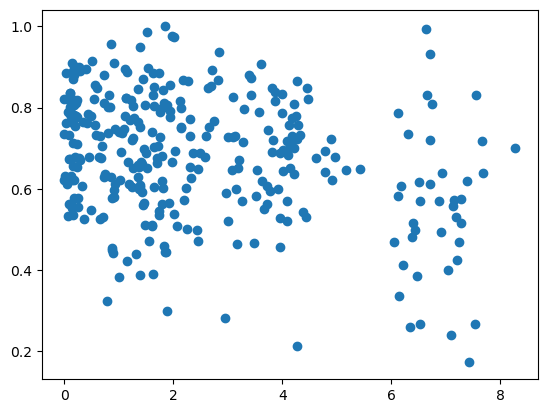

In [24]:
fig, ax = plt.subplots()
ax.scatter(y_pred.loc[:,"Age"], y_true.loc[:,"Age"])